In [1]:
import pandas as pd
import numpy as np
import re
import nltk
import string
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize, FreqDist, RegexpTokenizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_val_score, train_test_split

from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

import matplotlib.pyplot as plt
%matplotlib inline

pd.set_option("display.max_colwidth", None) 

In [2]:
tweet_df = pd.read_csv('train.csv')
tweet_df = tweet_df[['text', 'target']]

In [3]:
tweet_df.head()

,text,target
0,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,1
1,Forest fire near La Ronge Sask. Canada,1
2,All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected,1
3,"13,000 people receive #wildfires evacuation orders in California",1
4,Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school,1


In [4]:
tweet_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    7613 non-null   object
 1   target  7613 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 119.1+ KB


In [5]:
tweet_df['target'].value_counts()

0    4342
1    3271
Name: target, dtype: int64

In [6]:
stopwords_list = stopwords.words('english') + list(string.punctuation)
stopwords_list += ['http', 'https', 't.co', 'amp', 'co', 'û', 'û_', 'u']

stopwords_list

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [7]:
tweet_df['text']=tweet_df['text'].str.replace(r'(//t.co/)\w*', '')

In [8]:
def process_tweet(tweet):
    tok = RegexpTokenizer(r'\w+')
    lemm = WordNetLemmatizer()
    
    tokens = tok.tokenize(tweet)
    lemmas = [lemm.lemmatize(token.lower(), pos='v') for token in tokens]
    stopwords_removed = [lemma for lemma in lemmas if lemma not in stopwords_list]
    return stopwords_removed

In [9]:
tweet_df['processed_data'] = tweet_df['text'].map(process_tweet)
# tweet_df.drop('text', axis=1, inplace=True)
tweet_df.head()

,text,target,processed_data
0,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,1,"[deeds, reason, earthquake, may, allah, forgive, us]"
1,Forest fire near La Ronge Sask. Canada,1,"[forest, fire, near, la, ronge, sask, canada]"
2,All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected,1,"[residents, ask, shelter, place, notify, officer, evacuation, shelter, place, order, expect]"
3,"13,000 people receive #wildfires evacuation orders in California",1,"[13, 000, people, receive, wildfires, evacuation, order, california]"
4,Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school,1,"[get, send, photo, ruby, alaska, smoke, wildfires, pour, school]"


In [10]:
# tweet_df

In [11]:
true_tweets = tweet_df[tweet_df['target']==1]
false_tweets = tweet_df[tweet_df['target']==0]

In [12]:
total_vocab = set()
for tweet in tweet_df['processed_data']:
    total_vocab.update(tweet)
len(total_vocab)


15018

In [13]:
true_concat = []
for article in true_tweets['processed_data']:
    true_concat += article

In [14]:
true_freq_dist = FreqDist(true_concat) 
true_freq_dist.most_common(200)

[('fire', 273),
 ('bomb', 186),
 ('kill', 161),
 ('news', 140),
 ('flood', 122),
 ('disaster', 121),
 ('via', 121),
 ('get', 118),
 ('california', 115),
 ('crash', 115),
 ('suicide', 112),
 ('police', 109),
 ('train', 109),
 ('people', 106),
 ('attack', 106),
 ('home', 105),
 ('2', 103),
 ('like', 101),
 ('build', 98),
 ('storm', 96),
 ('say', 94),
 ('hiroshima', 92),
 ('burn', 87),
 ('go', 82),
 ('families', 81),
 ('emergency', 77),
 ('two', 74),
 ('live', 73),
 ('nuclear', 73),
 ('mh370', 72),
 ('collapse', 70),
 ('video', 69),
 ('wildfire', 69),
 ('accident', 68),
 ('report', 67),
 ('old', 67),
 ('cause', 65),
 ('one', 65),
 ('northern', 64),
 ('1', 63),
 ('dead', 63),
 ('time', 62),
 ('war', 62),
 ('watch', 61),
 ('legionnaires', 61),
 ('car', 60),
 ('bomber', 60),
 ('pm', 59),
 ('warn', 59),
 ('evacuate', 59),
 ('year', 58),
 ('confirm', 58),
 ('typhoon', 58),
 ('still', 57),
 ('obama', 57),
 ('new', 56),
 ('atomic', 56),
 ('japan', 56),
 ('fatal', 55),
 ('today', 55),
 ('look', 5

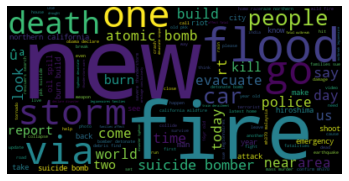

In [15]:
truecloud = WordCloud().generate(' '.join(true_concat))

plt.imshow(truecloud, interpolation='bilinear')
plt.axis('off')
plt.show();

In [16]:
false_concat = []
for article in false_tweets['processed_data']:
    false_concat += article

In [17]:
false_freq_dist = FreqDist(false_concat) 
false_freq_dist.most_common(200)

[('get', 312),
 ('like', 294),
 ('go', 197),
 ('new', 170),
 ('make', 133),
 ('one', 131),
 ('body', 119),
 ('love', 117),
 ('see', 115),
 ('2', 112),
 ('bag', 112),
 ('come', 109),
 ('say', 107),
 ('time', 106),
 ('think', 105),
 ('know', 102),
 ('would', 101),
 ('scream', 100),
 ('want', 99),
 ('via', 99),
 ('video', 96),
 ('burn', 96),
 ('people', 95),
 ('look', 91),
 ('let', 90),
 ('fire', 90),
 ('back', 88),
 ('take', 87),
 ('day', 86),
 ('full', 84),
 ('3', 82),
 ('wreck', 82),
 ('emergency', 81),
 ('fuck', 77),
 ('feel', 77),
 ('youtube', 76),
 ('us', 75),
 ('work', 72),
 ('still', 72),
 ('gt', 72),
 ('need', 72),
 ('drown', 72),
 ('panic', 69),
 ('good', 67),
 ('man', 66),
 ('blow', 66),
 ('sink', 66),
 ('world', 63),
 ('lol', 62),
 ('crush', 62),
 ('explode', 62),
 ('rt', 61),
 ('build', 61),
 ('life', 61),
 ('destroy', 60),
 ('first', 59),
 ('read', 59),
 ('last', 58),
 ('even', 58),
 ('watch', 58),
 ('way', 57),
 ('news', 57),
 ('help', 56),
 ('best', 55),
 ('5', 55),
 ('rea

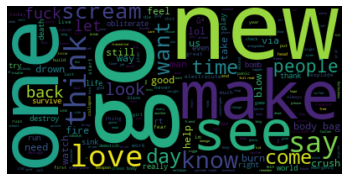

In [18]:
falsecloud = WordCloud().generate(' '.join(false_concat))

plt.imshow(falsecloud, interpolation='bilinear')
plt.axis('off')
plt.show();

In [19]:
X = tweet_df['text']
y = tweet_df['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=107, test_size=.2)

In [20]:
vectorizer = TfidfVectorizer(analyzer=process_tweet)

train_vec = vectorizer.fit_transform(X_train)

test_vec = vectorizer.transform(X_test)

In [21]:
train_vec.shape
# (num_tweets, num_unique_words)

(6090, 13081)

In [22]:
rf_classifier = RandomForestClassifier(n_estimators=100)

In [23]:
rf_classifier.fit(train_vec, y_train)

RandomForestClassifier()

In [24]:
cross_val_score(rf_classifier,
               train_vec, y_train,
                cv=5)

array([0.80295567, 0.77339901, 0.78078818, 0.77996716, 0.75615764])

In [25]:
rf_classifier.score(test_vec, y_test)

0.7944845699277742